# Task 3.: Eigenvalues -- Generation

## Task description

- Create a function named `make_ham` with three input arguments. The first two arguments `v` and `w` are real numbers, while the third one, named `dim` is an integer.
- The function should return a sparse matrix $H$ that is in a SciPy-supported CSC format. The matrix $H$ should bear the following structure: 

$$
H
=
\left(
    \begin{array}{cc}
        0             & \Gamma\\
        \Gamma^{\top} & 0
    \end{array}
\right)
$$ 

Where $\Gamma$ is a matrix with sizes `dim` $\times$ `dim` and $\Gamma^{\top}$ is the transpose of $\Gamma$. The structure of $\Gamma$ should be the following:

$$
\Gamma
=
\left(
    \begin{array}{cccc}
        v                       \\
        w & v                   \\
          & w & \ddots          \\
          &   & \ddots & \ddots
    \end{array}
\right)
$$

so the diagonal entries are filled with `v`s, and the subdiagonal consist of elements all equal to `w`.
- Ügyelj rá, hogy a `make_ham` függvényen belül ritka mátrixokkal és a rájuk vonatkozó ritkamátrix építő SciPy [rutinokkal](https://docs.scipy.org/doc/scipy/reference/sparse.html) hozd létre a megfelelő objektumokat. Semmiképp se hozzunk létre a $\Gamma$-t reprezentáló sűrű mátrixot (például NumPy `array` vagy NumPy `matrix` típusú) objektumot!
- Determine the `w`-dependence of the 12 smallest eigenvalues of the $H$ matrix created by the `make_ham` function, using the `eigsh` function from the `scipy.sparse.linalg` module. Let us choose `v = 1` and `dim = 3000` for this examination. A `w` értékeit a [0.99,1.01] intervallumban változtassuk, és legalább 100 pontban értékeljük ki!
- Create a graph and visualize the `w`-dependence of the eigenvalues on it using Matplotlib's [`scatter`](https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.pyplot.scatter.html) function!
- Describe in your own words, what is the difference between the spectra of the matrix in cases `w < 1` and `w > 1`? 

## Theoretical background

The matrix $H$ at first glance seems to be a so-called anti-diagonal matrix, which means it has non-zero elements only in its diagonal going from the upper right corner to the lower left corner. But in reality it is a block matrix, since $H$ could be partitioned into smaller, but well-defined matrices. In this case these blocks are denoted by the $\Gamma$ symbols in the anti-diagonal and the null matrices by the $0$ symbol in the diagonal blocks. The latter property makes $H$ not a true anti-diagonal matrix, but rather we can call it as "block anti-diagonal" (which is not an existing term actually).

The structure of the $\Gamma$ matrices are also given in the description. These matrices called as "bidiagonal", or as "lower bidiagonal" matrices in this case. In this case the transpose of $\Gamma$ looks like as follows:

$$
\Gamma^{\top}
=
\left(
    \begin{array}{cccc}
        v & w                   \\
          & v & w               \\
          &   & \ddots & \ddots \\
          &   &        & \ddots
    \end{array}
\right)
$$

#### Sources

[1] :

## Solving the task

In [39]:
import sys
import numpy as np
from scipy.sparse import csc_matrix, linalg

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from IPython.display import display, clear_output

### Just some matplotlib and seaborn parameter tuning

In [2]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

### Creating Hamiltonian

In [34]:
def make_ham(v, w, dim):

  # Assert all parameters are the correct types
  assert type(dim) == int, "Argument `dim` should be an integer!"
  assert ~isinstance(v, complex), "Argument `v` should be real!"
  assert ~isinstance(w, complex), "Argument `w` should be real!"

  # 1. GAMMA
  # Indeces of elements of Gamma matrix in the
  # upper right corner
  row_1 = np.array(
      [i for i in range(dim)] +       # Diagonal
      [i for i in range(1, dim)]      # Subdiagonal
  ) + 0                               # Absolute position
  col_1 = np.array(
      [i for i in range(dim)] +       # Diagonal
      [i for i in range(dim - 1)]     # Subdiagonal
  ) + dim                             # Absolute position
  data_1 = np.array(
      [v for _ in range(dim)] +       # Diagonal
      [w for _ in range(dim - 1)]     # Subdiagonal
  )

  # 2. GAMMA^T
  # Indeces of elements of the transpose of Gamma 
  # matrix in the lower left corner
  row_2 = np.array(
      [i for i in range(dim)] +       # Diagonal
      [i for i in range(dim - 1)]     # Superdiagonal
  ) + dim                             # Absolute position
  col_2 = np.array(
      [i for i in range(dim)] +       # Diagonal
      [i for i in range(1, dim)]      # Superdiagonal
  ) + 0                               # Absolute position
  data_2 = np.array(
      [v for _ in range(dim)] +       # Diagonal
      [w for _ in range(dim - 1)]     # Superdiagonal
  )

  # Concatenate into the final lists of elements and their indeces
  row = np.concatenate((row_1, row_2))
  col = np.concatenate((col_1, col_2))
  data = np.concatenate((data_1, data_2))

  # Create the sparse matrix in CSC format
  H = csc_matrix((data, (row, col)), shape=(2*dim, 2*dim)).toarray()

  # Test Hermitianness
  assert np.sum(np.matrix(H).H - np.matrix(H)) == 0, "Matrix isn't Hermitian!"

  return H

In [35]:
v = 1
w = 2
dim = 10

H = make_ham(v, w, dim)

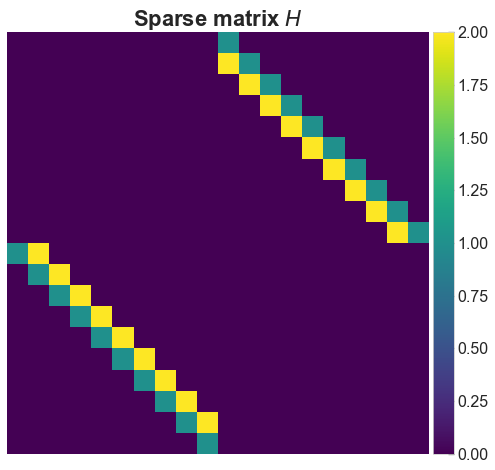

In [36]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*8))

axistitlesize = 22
axiscbarsize = 16

axes.axis('off')

im = axes.imshow(H, cmap='viridis')

axes.set_title('Sparse matrix $H$', fontsize=axistitlesize, fontweight='bold')

# Define colorbar axis
# Nice fit parameters from stackoverflow:
# https://stackoverflow.com/questions/23876588/matplotlib-colorbar-in-each-subplot
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
cbar = fig.colorbar(im, cax)
cbar.ax.tick_params(labelsize=axiscbarsize)

plt.show()

### Testing `w`-dependency of eigenvalues

In [42]:
%%time
# Constant parameters
v = 1
dim = 300

# Varying parameter
N = 101     # Number of w values checked
w = np.linspace(0.99, 1.01, N)

eigs = []
for w_i in tqdm(w):
  H = make_ham(v, w_i, dim)
  eig_vals = linalg.eigsh(H, k=6, which='SM', return_eigenvectors=False)
  eigs.append([w_i, eig_vals])

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:39<00:00,  1.01it/s]

CPU times: total: 6min 1s
Wall time: 1min 39s


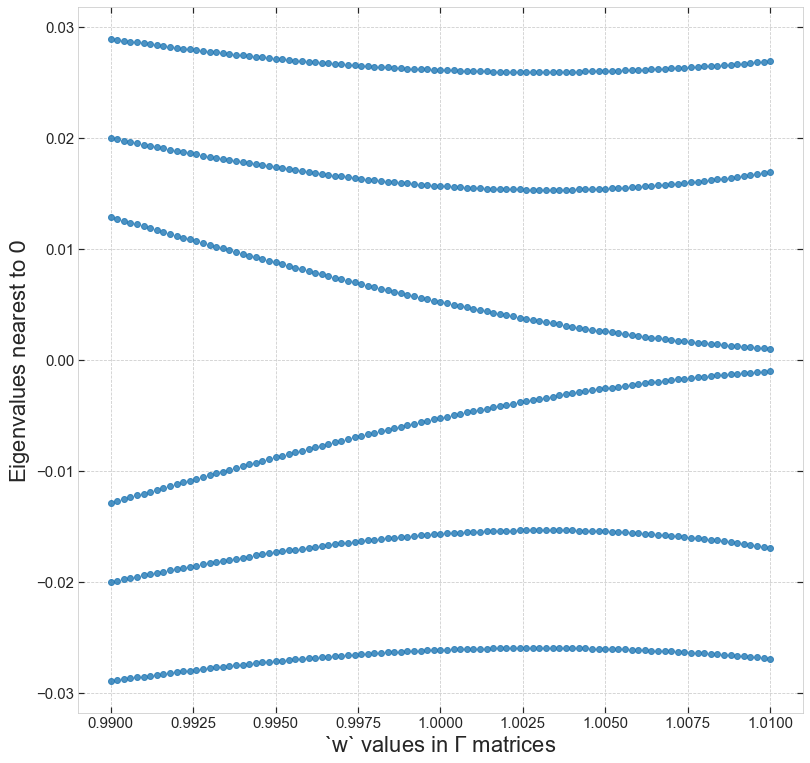

In [43]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*13, nrows*13))

axislabelsize = 22
axisticksize = 15

for (w_i, eig) in eigs:
  ax.scatter([w_i for _ in range(len(eig))], eig,
             color='C0', alpha=0.8)
    
ax.set_xlabel('`w` values in $\Gamma$ matrices', fontsize=axislabelsize)
ax.set_ylabel('Eigenvalues nearest to $0$', fontsize=axislabelsize)
ax.tick_params(axis='both', which='major', labelsize=axisticksize)
    
plt.show()